In [1]:
######################################################################
# Semi-Supervised Classification of Graph Nodes using Exponential Decay
# L42: Assessment 2
# Jan Ondras (jo356), Trinity College
######################################################################
# My Method - MLP_lambda:    training and testing, PUBMED dataset
######################################################################

#############################################################################################################
# Load data for final training + testing, uses my constructed EDNI features FOR PUBMED DATASET
#############################################################################################################

import keras
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import time
from gcn.utils import *

dataset_type = 'pubmed'

# Load data
_, _, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(dataset_type)

if dataset_type == 'pubmed':
    N_classes = 3
    N_features = 500
    N_nodes = 19717
    N_edges = 44327 #44338 - incorrect in GCN paper !
    if N_classes != y_train.shape[1]:
        raise ValueError("Dataset dimensions differ from expected!")
else:
    raise ValueError("Dataset not supported!")
print dataset_type, "dataset:", "#classes =", N_classes, ", #features =", N_features, ", #nodes =", N_nodes, ", #edges =", N_edges

# Prepare labels
y_train = y_train[train_mask]
y_val = y_val[val_mask]
y_test = y_test[test_mask]

train_batch_size = len(y_train)
val_batch_size = len(y_val)
test_batch_size = len(y_test)

print "Labels shapes (train, valid, test):", y_train.shape, y_val.shape, y_test.shape

Using TensorFlow backend.


pubmed dataset: #classes = 3 , #features = 500 , #nodes = 19717 , #edges = 44327
Labels shapes (train, valid, test): (60, 3) (500, 3) (1000, 3)


In [14]:
#############################################################################################################
# Load tuned parameters - from Baseline MLP validation on Cora dataset
#############################################################################################################

ID = 0 # zeroth trial,  smaller # of hidden sizes
ID = 1 # first ok trial, higher # of hidden sizes

# data = np.load('./../../../Dataset/baseline_' + str(ID) + '.npz')
data = np.load('./../../../Dataset/baseline_' + str(ID) + '_PubMed.npz') ############## CHOOSE !!!
vals = data['vals']
vals_std = data['vals_std']
N_hl_range = data['N_hl_range']
N_hu_range = data['N_hu_range']
N_runs = data['N_runs']
dropout = data['dropout']
epochs = data['epochs']

best_N_hl = N_hl_range[np.argmax(vals) // len(N_hu_range)]
best_N_hu = N_hu_range[np.argmax(vals) % len(N_hu_range)]

print "# hidden layers range", N_hl_range
print "# hidden units range", N_hu_range
print "Optimal number of hidden layers: ", best_N_hl
print "Optimal number of hidden units: ",  best_N_hu
print "dropout", dropout, "\tN_runs", N_runs

# hidden layers range [ 1  2  3  4  5  6  7  8  9 10]
# hidden units range [10 15 20 25 30 35 40 45 50 55 60 65 70 75 80]
Optimal number of hidden layers:  2
Optimal number of hidden units:  20
dropout 0.5 	N_runs 100


In [15]:
#############################################################################################################
# Final train & Test for each LAMBDA
# Using best N_hl and N_hu found for the baseline method on Cora dataset
# no feature scaling
#############################################################################################################
# for all possible lambdas
lambdas = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 
           6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 
           100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]
print "Processing", len(lambdas), "lambdas."

test_acc = []
test_acc_std = []

N_hl = best_N_hl
N_hu = best_N_hu

for LAMBDA in lambdas: 

    st = time.time()
    X = np.load('./../../../Dataset/Features_PubMed/f_' + str(LAMBDA) + '_.npz')['X']
    if LAMBDA != np.load('./../../../Dataset/Features_PubMed/f_' + str(LAMBDA) + '_.npz')['LAMBDA']:
        raise ValueError("Lambdas don't agree!")
    print "Max and Min feature value in new feature set:", np.max(X), np.min(X), X.shape

    X_train = X[train_mask]
    X_val   = X[val_mask]
    X_test  = X[test_mask]

    # Train & test for this LAMBDA
    model = Sequential()
    model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
    model.add(Dropout(dropout))
    for i in range(1, N_hl):
        model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
    model.add(Dense(N_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
#     print model.summary()
    early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

    test_acc_actual = []
    for i in range(N_runs):
        model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
                   validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

        test_acc_actual.append( model.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=0)[1] )
        
    test_acc.append( np.mean(test_acc_actual) )
    test_acc_std.append( np.std(test_acc_actual) )  
    
    # Save testing results, 1=from baseline_1, 0=no feature scaling
#     np.savez('./../../../Dataset/MyMethodSimpleX/mm_simple_1_0_' + str(LAMBDA) + '_.npz', 
#              test_acc=test_acc[-1], test_acc_std=test_acc_std[-1], LAMBDA=LAMBDA)
    
    print "Time taken: ", time.time()-st, (time.time()-st)/60. # 20sec for one lambda
    
test_acc = np.array(test_acc)
test_acc_std = np.array(test_acc_std)

Processing 36 lambdas.
Max and Min feature value in new feature set: 1.27436321844 3.88783913973e-19 (19717, 500)
Time taken:  38.2351388931 0.637257047494
Max and Min feature value in new feature set: 3.11254109214 1.64227472877e-09 (19717, 500)
Time taken:  36.2238340378 0.603732200464
Max and Min feature value in new feature set: 8.98790068574 3.62163863392e-06 (19717, 500)
Time taken:  40.1343829632 0.668912100792
Max and Min feature value in new feature set: 17.0244838427 0.000189873539619 (19717, 500)
Time taken:  44.1478309631 0.73579788208
Max and Min feature value in new feature set: 27.3523267862 0.0021006518842 (19717, 500)
Time taken:  41.662858963 0.694381550948
Max and Min feature value in new feature set: 38.3791569294 0.0103476958446 (19717, 500)
Time taken:  41.1011018753 0.685018980503
Max and Min feature value in new feature set: 49.4997329268 0.032651031543 (19717, 500)
Time taken:  37.9255018234 0.632093298435
Max and Min feature value in new feature set: 60.360596

In [37]:
# To save the testing results
# print test_acc.tolist()
# print test_acc_std.tolist()

test_acc = [0.7174999994039536, 0.7471500039100647, 0.774640000462532, 0.7683999979496002, 0.7505900034308434, 0.6224899998307228, 0.6330000001192093, 0.6187900030612945, 0.2742100030183792, 0.320920005440712, 0.2671200014650822, 0.22194000363349914, 0.20457000583410262, 0.34262999311089515, 0.2659700006246567, 0.3254799953103065, 0.2912999993562698, 0.25649000465869903, 0.302199998497963, 0.31871999859809874, 0.24613000571727753, 0.35575000286102293, 0.2866900062561035, 0.32313999891281125, 0.3011500036716461, 0.3843000054359436, 0.1916500061750412, 0.33890999913215636, 0.40730000436306, 0.38228999137878417, 0.4120999902486801, 0.40700000524520874, 0.40833998799324034, 0.34117000579833984, 0.396329990029335, 0.32833999693393706]
test_acc_std = [0.00386135053416318, 0.012783096339805046, 0.01532156635450226, 0.015524818354550494, 0.04197668352289177, 0.05846494641923644, 0.031639533234629, 0.03854070344463223, 0.11302992859181273, 0.11032829781271254, 0.11271692729313616, 0.08951566932832222, 0.06990797222540596, 0.10879996346792398, 0.11218594912608768, 0.11612393735633647, 0.11585606632560781, 0.10900206023769364, 0.11531989462207289, 0.11328442077837202, 0.10348059057853742, 0.0960774012064291, 0.1132955148463313, 0.112084427661421, 0.11410279019483521, 0.06809999942779542, 0.05078116843135463, 0.10654304631759128, 0.0013076658378649798, 0.07821115606342283, 0.0021424222287607458, 0.0, 0.0326199972629547, 0.10300398497972649, 0.059367503994063105, 0.1112717514590238]

test_acc = np.array(test_acc)
test_acc_std = np.array(test_acc_std)

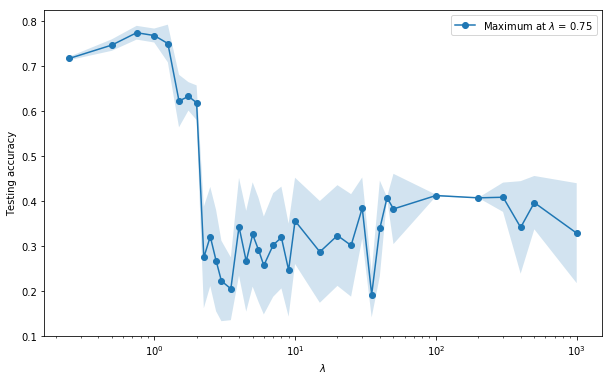

Max Testing accuracy:  0.774640000463 +/- 0.0153215663545 for 0.75
PubMed, using PubMed best params


In [40]:
#############################################################################################################
# Show testing results, for chosen lambdas
#############################################################################################################

lambdas = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 
           6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 
           100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]

N_std = 1
showN = 36 # max 36
plt.figure(figsize=[10,6])
plt.plot(lambdas[:showN], test_acc[:showN],'o-')
plt.fill_between(lambdas[:showN],  test_acc[:showN]-N_std*test_acc_std[:showN],  test_acc[:showN]+N_std*test_acc_std[:showN], alpha=.2)
# plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('$\lambda$')
plt.ylabel('Testing accuracy')
#plt.xticks(lambdas[:showN], lambdas[:showN])#, rotation=45)
plt.legend(['Maximum at $\lambda$ = '+str(lambdas[np.argmax(test_acc)])])
plt.xscale('log')
plt.show()

print "Max Testing accuracy: ",np.max(test_acc), "+/-", test_acc_std[np.argmax(test_acc)], "for", lambdas[np.argmax(test_acc)]
print "PubMed, using PubMed best params"

In [ ]:
Max Testing accuracy:  0.774640000463 for 0.75